In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import os

sns.set_style('dark')

%load_ext autotime
%matplotlib inline

FILE = "PGE.csv"
DIRI = "data"
MIN_K = 3
MAX_K = 25 # Assigned because of practicality

In [3]:
file_path = os.path.join(DIRI, FILE)
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_time             43848 non-null  object
 1   raw demand (MW)       43848 non-null  object
 2   category              43848 non-null  object
 3   cleaned demand (MW)   43848 non-null  int64 
 4   forecast demand (MW)  43848 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
time: 92 ms


In [4]:
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW)
0,2015-07-02 00:00:00,MISSING,MISSING,2740,MISSING
1,2015-07-02 01:00:00,MISSING,MISSING,3287,MISSING
2,2015-07-02 02:00:00,MISSING,MISSING,3264,MISSING
3,2015-07-02 03:00:00,MISSING,MISSING,3192,MISSING
4,2015-07-02 04:00:00,MISSING,MISSING,3136,MISSING
...,...,...,...,...,...
43843,2020-07-01 19:00:00,2315,OKAY,2315,2359
43844,2020-07-01 20:00:00,2337,OKAY,2337,2392
43845,2020-07-01 21:00:00,2325,OKAY,2325,2391
43846,2020-07-01 22:00:00,2308,OKAY,2308,2390


time: 23 ms


In [5]:
# Convert the date string to a pandas datetime
df["date_time"] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df["date"] = df["date_time"].dt.date  # Add separate date string 
df["hour"] = df["date_time"].dt.hour  # Add separate hour string
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW),date,hour
0,2015-07-02 00:00:00,MISSING,MISSING,2740,MISSING,2015-07-02,0
1,2015-07-02 01:00:00,MISSING,MISSING,3287,MISSING,2015-07-02,1
2,2015-07-02 02:00:00,MISSING,MISSING,3264,MISSING,2015-07-02,2
3,2015-07-02 03:00:00,MISSING,MISSING,3192,MISSING,2015-07-02,3
4,2015-07-02 04:00:00,MISSING,MISSING,3136,MISSING,2015-07-02,4
...,...,...,...,...,...,...,...
43843,2020-07-01 19:00:00,2315,OKAY,2315,2359,2020-07-01,19
43844,2020-07-01 20:00:00,2337,OKAY,2337,2392,2020-07-01,20
43845,2020-07-01 21:00:00,2325,OKAY,2325,2391,2020-07-01,21
43846,2020-07-01 22:00:00,2308,OKAY,2308,2390,2020-07-01,22


time: 79 ms


In [6]:
# Drop all columns except "Cleaned Demand (MW)"
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_demand = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)").copy()
df_demand

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,2740,3287,3264,3192,3136,2974,2773,2515,2271,2121,...,2232,2421,2602,2763,2900,3026,3161,3191,3306,3363
2015-07-03,3445,3443,3410,3308,3225,3072,2807,2567,2329,2137,...,2038,2196,2349,2509,2650,2797,2892,2935,3024,3116
2015-07-04,3177,3169,3223,3093,3040,2926,2748,2485,2254,2080,...,1903,1996,2136,2276,2414,2568,2669,2720,2795,2853
2015-07-05,2852,2901,2870,2780,2690,2589,2473,2275,2127,1971,...,1780,1877,2041,2115,2320,2407,2510,2642,2702,2769
2015-07-06,2832,2880,2942,2842,2850,2702,2527,2301,2073,1933,...,2099,2247,2392,2598,2712,2839,2950,3026,3145,3158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,3145,3190,3111,2959,2790,2673,2491,2274,2061,1909,...,1763,1865,1978,2091,2145,2196,2221,2230,2227,2216
2020-06-28,2244,2282,2257,2200,2144,2122,2028,1879,1737,1662,...,1618,1703,1835,1946,2033,2077,2113,2129,2118,2105
2020-06-29,2152,2220,2250,2224,2184,2153,2035,1868,1737,1650,...,1914,2070,2175,2241,2297,2329,2358,2358,2376,2399


time: 49 ms



k =  3 
Magnitude =  1331093899.7633398 
Sizes =  [328, 666, 833] 
Silhouetten Score =  0.34846181989626945 
Davies-Bouldin Score =  1.0602941124047838

k =  4 
Magnitude =  1123294272.857211 
Sizes =  [634, 259, 547, 387] 
Silhouetten Score =  0.2737852585961638 
Davies-Bouldin Score =  1.1524803605708729

k =  5 
Magnitude =  951885447.6333563 
Sizes =  [625, 507, 328, 233, 134] 
Silhouetten Score =  0.292187709650266 
Davies-Bouldin Score =  1.0825803229952746

k =  6 
Magnitude =  811046152.5350707 
Sizes =  [576, 117, 374, 301, 279, 180] 
Silhouetten Score =  0.3071567010817496 
Davies-Bouldin Score =  1.081283450756063

k =  7 
Magnitude =  726472117.828428 
Sizes =  [110, 288, 285, 251, 532, 275, 86] 
Silhouetten Score =  0.2935693343681927 
Davies-Bouldin Score =  1.058977064304163

k =  8 
Magnitude =  656906785.7163732 
Sizes =  [76, 163, 244, 242, 302, 472, 261, 67] 
Silhouetten Score =  0.29334043332765763 
Davies-Bouldin Score =  1.030585902031044

k =  9 
Magnitude =  59

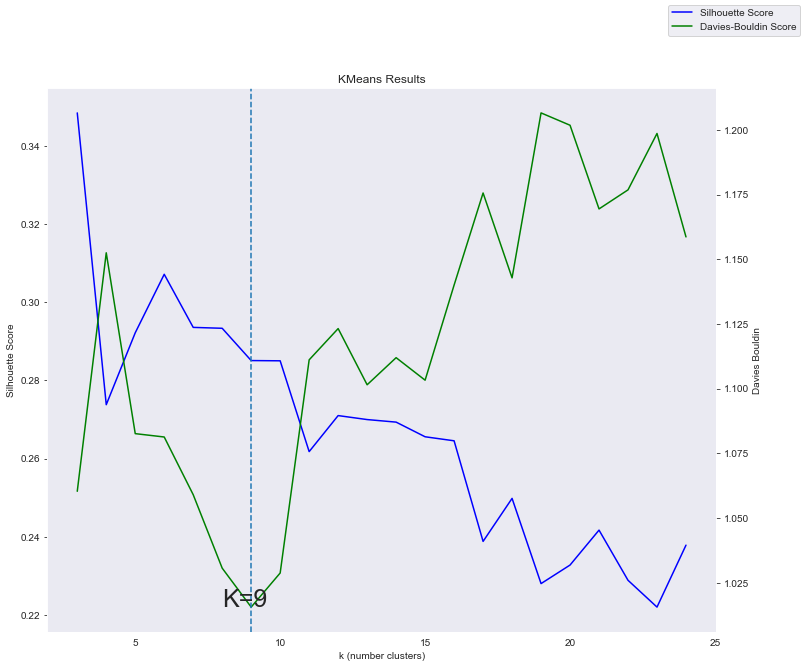

time: 10.2 s


In [7]:
# Save cluster magnitudes (sum of sqaured distances to the centroid) in a dataframe
# where index = number of clusters
#

# .inertia_ returns the sum of squared distances of samples to their closest cluster center
# .cluster_centers_  returns array wuth coordinates of cluster centers
# .labels_ returns the cluster label of each example in order

cluster_stats = pd.DataFrame(index=range(MIN_K, MAX_K), columns=["Magnitude", "Silhouette", "DB"])

for k in cluster_stats.index:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_demand)
    clusters = kmeans.labels_
    cluster_stats["Magnitude"][k] = kmeans.inertia_
    
    # For each cluster label, find how many examples are part of that cluster
    cluster_sizes = []
    for i in range(k):
        cluster_sizes.append(len(np.where(clusters == i)[0]))

    # Calculate the average Silhouette Score for each cluster
    cluster_stats['Silhouette'][k] = silhouette_score(df_demand, kmeans.labels_)

    # Davies Boulding score
    cluster_stats['DB'][k] = davies_bouldin_score(df_demand, kmeans.labels_)
    
    print("\nk = ", k,
     "\nMagnitude = ", kmeans.inertia_,
     "\nSizes = ", cluster_sizes, 
     "\nSilhouetten Score = ", cluster_stats['Silhouette'][k], 
     "\nDavies-Bouldin Score = ", cluster_stats['DB'][k])
    

fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title("KMeans Results")
ax.plot(cluster_stats['Silhouette'], color='blue', label='Silhouette Score')
ax.set_xlabel("k (number clusters)")
ax.set_ylabel("Silhouette Score")

ax2 = ax.twinx()
ax2.plot(cluster_stats['DB'], color='green', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies Bouldin')

ax2.axvline(x=MIN_K+np.argmin(cluster_stats['DB']), linestyle='--')
ax2.text(MIN_K+np.argmin(cluster_stats['DB'])-1,
 np.min(cluster_stats['DB']),
 f"K={MIN_K+np.argmin(cluster_stats['DB'])}", 
 fontsize=25)

fig.legend()

fig.savefig(f"silhouette_graphs/kmeans_results")

cluster_stats.to_csv(f"kmeans_results")

C:\Users\jimpg\AppData\Local\Temp/ipykernel_18612/3604848054.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_silho = pd.Series(index=range(3, MAX_K))


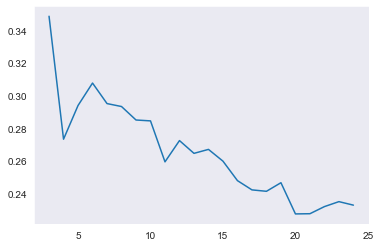

time: 17.5 s


In [8]:
# Perform silhouette analysis on a point-by-point basis
avg_silho = pd.Series(index=range(3, MAX_K))

for k in range(3, MAX_K):
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(df_demand)

    silhouette_avg = silhouette_score(df_demand, cluster_labels)
    sample_silhouette_values = silhouette_samples(df_demand, cluster_labels)

    avg_silho[k] = silhouette_avg

    y_lower = 10
    for i in range(k): # for each cluster created
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples


    plt.title(f"Silhouette Coefficients for All Points, k={k}")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.savefig(f"silhouette_graphs/kmeans_silhouette_{k}.png")
    plt.close()

plt.plot(avg_silho)

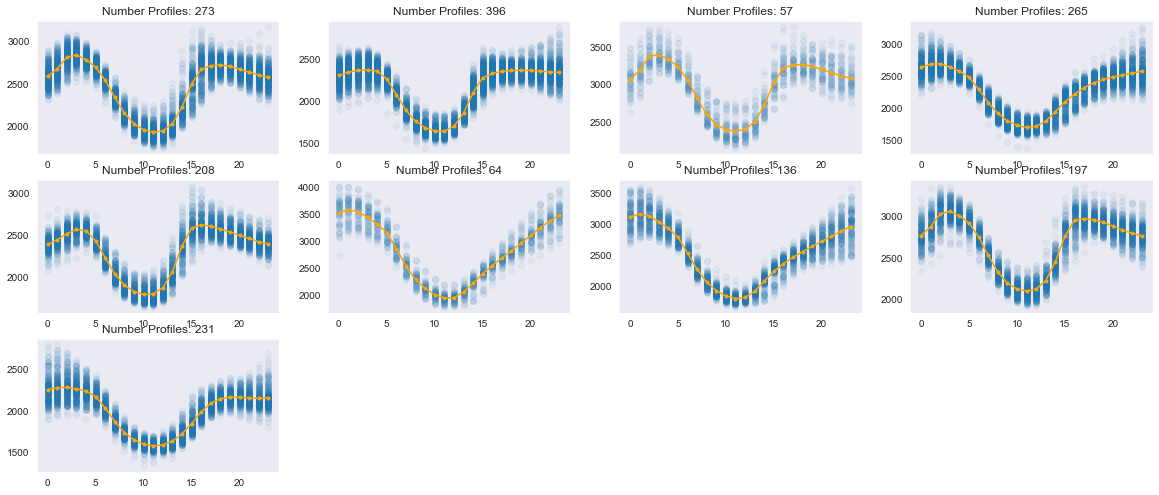

time: 2.71 s


In [9]:
from matplotlib.gridspec import GridSpec

chosen_k = 9

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)

kmeans = KMeans(n_clusters=chosen_k, random_state=0).fit(df_demand)
clusters = kmeans.labels_
df_demand["profile_cluster"] = clusters

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids = centroids.T

for k in range(chosen_k):
    df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == k].reset_index()
    df_cluster_loads.drop("profile_cluster", axis=1, inplace=True)
    df_cluster_loads = df_cluster_loads.melt(id_vars="date")
    ax = fig.add_subplot(gs[k])
    ax.scatter(df_cluster_loads["hour"], df_cluster_loads["value"], alpha=0.05)
    ax.plot(centroids[k][0:24], '.-', color='orange')

    ax.set_title(f'Number Profiles: {len(df_demand.loc[df_demand["profile_cluster"] == k])}')


fig.savefig(f'silhouette_graphs/kmeans_{chosen_k}_load_profiles')

Let's figure out what kind of day each cluster represents.

In [11]:
def is_weekday(x):
    if x < 5:
        return True
    else:
        return False
    
    
def season_name(x):
    if x == 1:
        return "Winter"
    if x == 2:
        return "Spring"
    if x == 3:
        return "Summer"
    if x == 4:
        return "Fall"

time: 999 µs


In [69]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
df_demand.index = pd.to_datetime(df_demand.index)

df_demand["weekday"] = df_demand.index.dayofweek
df_demand["season num"] = df_demand.index.month%12 // 3 + 1

df_demand["is weekday"] = df_demand["weekday"].apply(lambda x: is_weekday(x))
df_demand["season"] = df_demand["season num"].apply(lambda x: season_name(x))

df_clusters = df_demand[["profile_cluster", "is weekday", "season", "season num"]]
df_clusters.columns = ["profile_cluster", "is weekday", "season", "season num"]

for k in range(MAX_K):
    dfk = df_clusters.loc[df_clusters["profile_cluster"] == k]
    print(dfk.value_counts())

profile_cluster  is weekday  season  season num
0                True        Winter  1             105
                 False       Winter  1              60
                 True        Fall    4              58
                             Spring  2              31
                 False       Spring  2              11
                             Fall    4               7
                 True        Summer  3               1
dtype: int64
profile_cluster  is weekday  season  season num
1                True        Spring  2             142
                             Fall    4             129
                             Summer  3              79
                 False       Spring  2              29
                             Fall    4              15
                             Winter  1               1
                 True        Winter  1               1
dtype: int64
profile_cluster  is weekday  season  season num
2                True        Winter  1             49
      

In [70]:
def cluster_similarity(x, centroid):
    # input is all rows belonging to a cluster
    total = 0
    
    for row in range(len(x)):
        for hour in range(23):
            # absolute diff between centroid hourly load and actual
            total += abs(x[hour][row] - centroid[hour])
    
    return total/len(x)

time: 1 ms


In [71]:
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_loads = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)").copy()
df_loads["profile_cluster"] = clusters
df_loads

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,profile_cluster
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,2740,3287,3264,3192,3136,2974,2773,2515,2271,2121,...,2421,2602,2763,2900,3026,3161,3191,3306,3363,5
2015-07-03,3445,3443,3410,3308,3225,3072,2807,2567,2329,2137,...,2196,2349,2509,2650,2797,2892,2935,3024,3116,5
2015-07-04,3177,3169,3223,3093,3040,2926,2748,2485,2254,2080,...,1996,2136,2276,2414,2568,2669,2720,2795,2853,6
2015-07-05,2852,2901,2870,2780,2690,2589,2473,2275,2127,1971,...,1877,2041,2115,2320,2407,2510,2642,2702,2769,3
2015-07-06,2832,2880,2942,2842,2850,2702,2527,2301,2073,1933,...,2247,2392,2598,2712,2839,2950,3026,3145,3158,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,3145,3190,3111,2959,2790,2673,2491,2274,2061,1909,...,1865,1978,2091,2145,2196,2221,2230,2227,2216,3
2020-06-28,2244,2282,2257,2200,2144,2122,2028,1879,1737,1662,...,1703,1835,1946,2033,2077,2113,2129,2118,2105,8
2020-06-29,2152,2220,2250,2224,2184,2153,2035,1868,1737,1650,...,2070,2175,2241,2297,2329,2358,2358,2376,2399,1


time: 48 ms


In [72]:
cluster_sims = []
for k in range(chosen_k):    
    input_x = df_loads.loc[kmeans.labels_ == k].reset_index()
    cluster_sims.append(cluster_similarity(input_x, centroids[k]))
    print(f"\nCluster {k}:", cluster_sims[k])


Cluster 0: 2015.4810610634795

Cluster 1: 1585.0120906029877

Cluster 2: 2801.144352108341

Cluster 3: 2245.5683303666674

Cluster 4: 1900.1838480029603

Cluster 5: 2780.2265625

Cluster 6: 2478.238429930794

Cluster 7: 2168.8271792625437

Cluster 8: 1725.2065366091306
time: 615 ms


In [73]:
df_clusters['year'] = df_clusters.index.year
df_clusters['day of year'] = df_clusters.index.dayofyear

dset = df_clusters.copy()
dset = dset.reset_index()
dset = dset.melt(id_vars=["year", "day of year"], value_vars='profile_cluster')

dset

C:\Users\jimpg\AppData\Local\Temp/ipykernel_18612/2624806095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['year'] = df_clusters.index.year
C:\Users\jimpg\AppData\Local\Temp/ipykernel_18612/2624806095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['day of year'] = df_clusters.index.dayofyear


,year,day of year,variable,value
0,2015,183,profile_cluster,5
1,2015,184,profile_cluster,5
2,2015,185,profile_cluster,6
3,2015,186,profile_cluster,3
4,2015,187,profile_cluster,6
...,...,...,...,...
1822,2020,179,profile_cluster,3
1823,2020,180,profile_cluster,8
1824,2020,181,profile_cluster,1
1825,2020,182,profile_cluster,1


time: 29 ms


In [74]:
# dset used to represent cluster for everyday over dataset
dset.rename(columns = {"value":"cluster"}, inplace=True)
dset = dset.pivot(index="year", columns="day of year", values="cluster")
dset

day of year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,0.0,0.0,0.0,7.0,7.0,7.0,2.0,NaN
2016,7.0,7.0,2.0,2.0,2.0,2.0,7.0,7.0,0.0,0.0,...,2.0,7.0,7.0,0.0,7.0,7.0,7.0,7.0,7.0,7.0
2017,7.0,7.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,7.0,7.0,7.0,7.0,2.0,7.0,6.0,3.0,0.0,NaN
2018,0.0,7.0,7.0,7.0,7.0,0.0,0.0,0.0,7.0,7.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,NaN
2019,0.0,7.0,7.0,0.0,0.0,3.0,7.0,7.0,7.0,0.0,...,0.0,7.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,NaN
2020,3.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 41.3 ms


In [77]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
# NOTE: Monday = 0
def day_type_calc(season, weekday):
    # Weekdays
    if weekday:
        return season
    # Weekends
    else:
        return season + 4



time: 1 ms


In [78]:
df_clusters["day type"] = df_clusters["season num"] + df_clusters["is weekday"]*4
df_clusters

C:\Users\jimpg\AppData\Local\Temp/ipykernel_18612/251835812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters["day type"] = df_clusters["season num"] + df_clusters["is weekday"]*4


,profile_cluster,is weekday,season,season num,year,day of year,day type
date,,,,,,,
2015-07-02,5,True,Summer,3,2015,183,7
2015-07-03,5,True,Summer,3,2015,184,7
2015-07-04,6,False,Summer,3,2015,185,3
2015-07-05,3,False,Summer,3,2015,186,3
2015-07-06,6,True,Summer,3,2015,187,7
...,...,...,...,...,...,...,...
2020-06-27,3,False,Summer,3,2020,179,3
2020-06-28,8,False,Summer,3,2020,180,3
2020-06-29,1,True,Summer,3,2020,181,7


time: 18 ms


day of year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,-1.0
2016,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,...,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0
2017,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,...,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,-1.0
2018,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,...,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,-1.0
2019,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,-1.0
2020,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


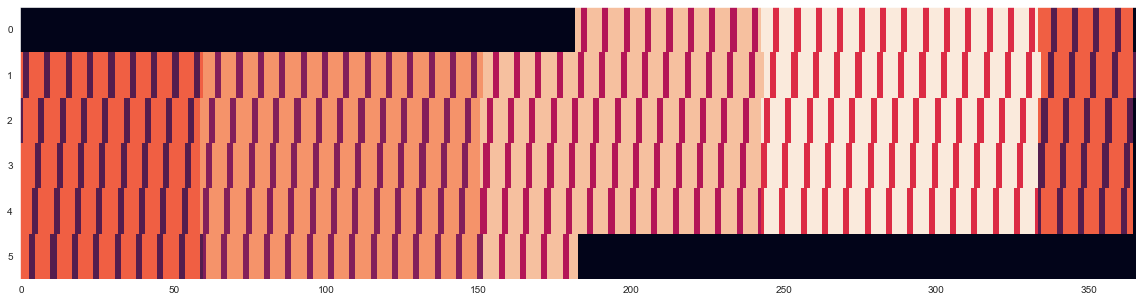

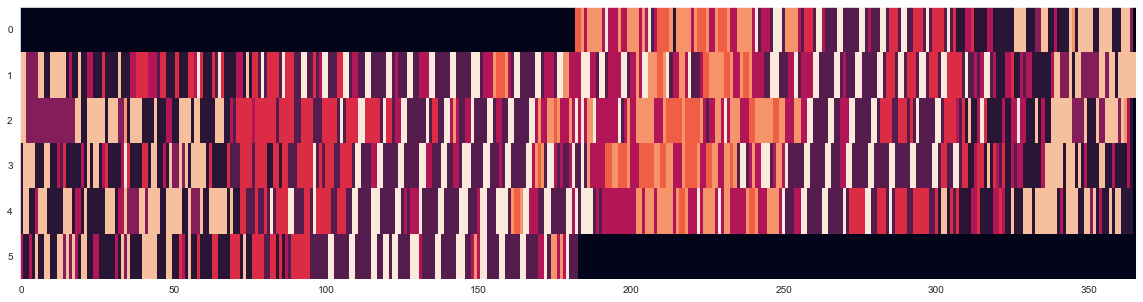

time: 624 ms


In [80]:
day_type = df_clusters[["day type", "year", "day of year"]]
day_type = day_type.pivot(index = "year", columns = "day of year", values = "day type")
day_type.fillna(-1, inplace=True)

plt.figure(figsize=(20, 5))
plt.imshow(day_type, aspect='auto')

dset.fillna(-1, inplace=True)
plt.figure(figsize=(20, 5))
plt.imshow(dset, aspect='auto')
day_type

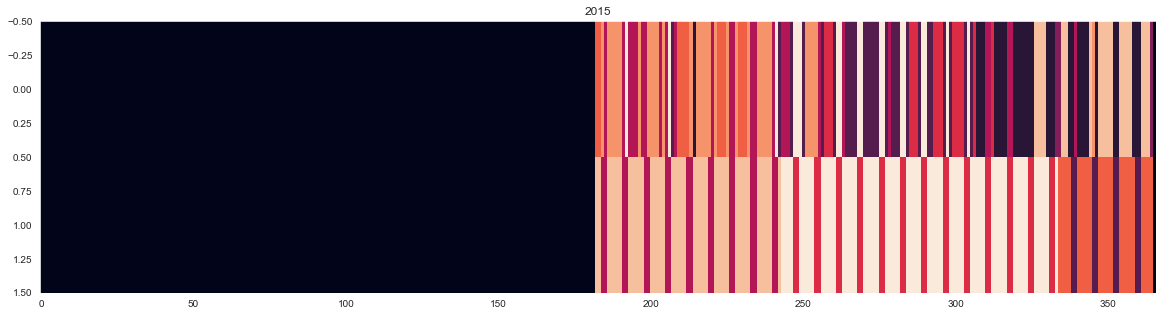

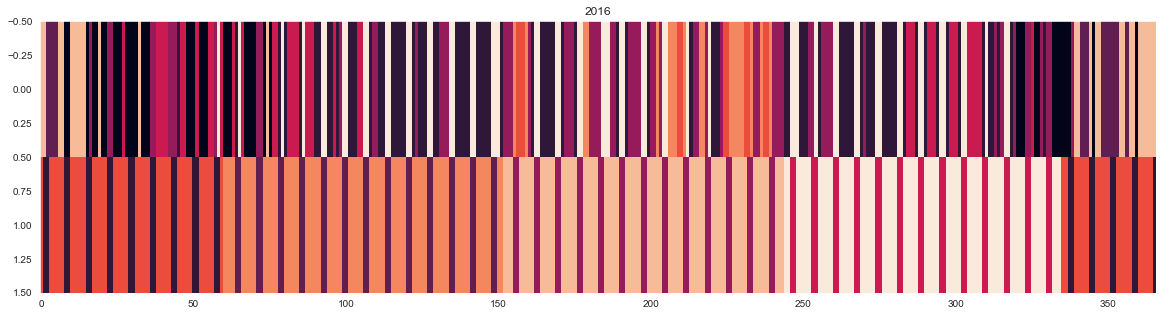

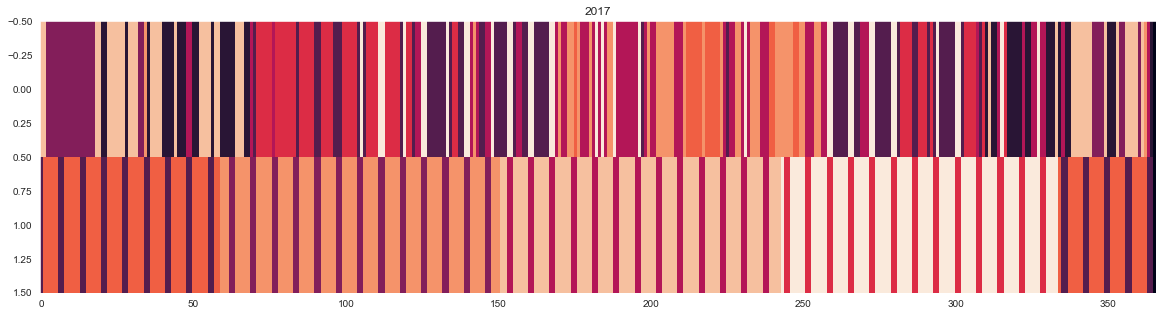

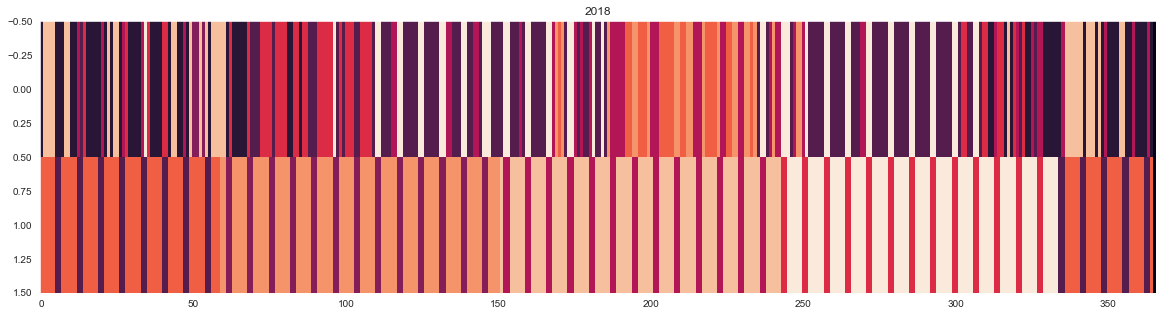

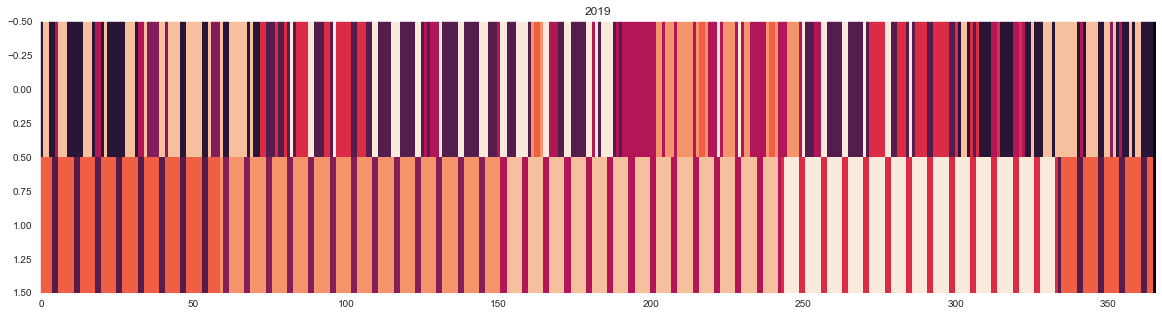

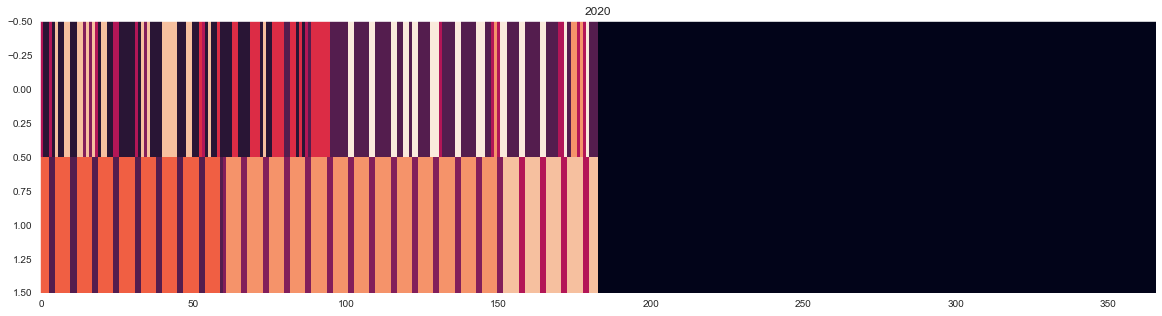

time: 2.07 s


In [114]:
for year in dset.index:
    dset_temp = dset.loc[dset.index == year].reset_index().drop('year', axis=1)
    dset_temp = dset_temp.append(day_type.loc[day_type.index == year].reset_index().drop('year', axis=1))
    plt.figure(figsize=(20, 5))
    plt.imshow(dset_temp, aspect='auto')
    plt.title(year)

In [187]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
def reverse_day_type_calc(day_type):
    # Weekdays
    if day_type == 1:
        return 'Winter Weekday'
    if day_type == 2:
        return 'Spring Weekday'
    if day_type == 3:
        return 'Summer Weekday'
    if day_type == 4:
        return 'Fall Weekday'
    if day_type == 5:
        return 'Winter Weekend'
    if day_type == 6:
        return 'Spring Weekend'
    if day_type == 7:
        return 'Summer Weekend'
    if day_type == 8:
        return 'Fall Weekend'

time: 2 ms


In [201]:
cluster_spread = df_clusters.groupby(['day type'])['profile_cluster'].value_counts()
cluster_spread = pd.DataFrame(cluster_spread)
cluster_spread.columns = ['count']
cluster_spread.reset_index(inplace=True)

for i in range(1, 9):
    max_cluster = cluster_spread[['count', 'profile_cluster']].loc[cluster_spread['day type']  == i]
    max_cluster = max_cluster.loc[max_cluster['count'] == max_cluster['count'].max()]
    print(f"Most Frequent Cluster for {reverse_day_type_calc(i)}:", max_cluster['profile_cluster'].values)

Most Frequent Cluster for Winter Weekday: [0]
Most Frequent Cluster for Spring Weekday: [8]
Most Frequent Cluster for Summer Weekday: [8]
Most Frequent Cluster for Fall Weekday: [8]
Most Frequent Cluster for Winter Weekend: [7]
Most Frequent Cluster for Spring Weekend: [1]
Most Frequent Cluster for Summer Weekend: [6]
Most Frequent Cluster for Fall Weekend: [1]
time: 29 ms


In [200]:
cluster_spread = df_clusters.groupby(['day type'])['profile_cluster'].value_counts()
cluster_spread = pd.DataFrame(cluster_spread)
cluster_spread.columns = ['count']
cluster_spread.reset_index(inplace=True)

for i in range(9):
    max_cluster = cluster_spread[['day type', 'count']].loc[cluster_spread['profile_cluster']  == i]
    max_cluster = max_cluster.loc[max_cluster['count'] == max_cluster['count'].max()]
    print(f"Most Frequent Day Type for Cluster {i}:", reverse_day_type_calc(max_cluster['day type'].values))


Most Frequent Day Type for Cluster 0: Winter Weekend
Most Frequent Day Type for Cluster 1: Spring Weekend
Most Frequent Day Type for Cluster 2: Winter Weekend
Most Frequent Day Type for Cluster 3: Summer Weekend
Most Frequent Day Type for Cluster 4: Spring Weekend
Most Frequent Day Type for Cluster 5: Summer Weekend
Most Frequent Day Type for Cluster 6: Summer Weekend
Most Frequent Day Type for Cluster 7: Winter Weekend
Most Frequent Day Type for Cluster 8: Fall Weekday
time: 27 ms
